In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import optuna
import optuna.visualization as vis
import shap
shap.initjs()
import seaborn as sns
import random
import os
import sklearn
from shapely import wkt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report, ConfusionMatrixDisplay
from scipy.stats import chi2_contingency
import joblib
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_curve, f1_score


In [4]:
sklearn.set_config(transform_output="pandas")

## Imputación

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

class AgregadorEspacial(BaseEstimator, TransformerMixin):
    def __init__(self, shapefile_path):
        self.shapefile_path = shapefile_path
        self.gdf_regiones = None
        self.stations_points = {
            "Albury": "POINT(146.91583 -36.08056)",
            "BadgerysCreek": "POINT(150.75222 -33.87972)",
            "Cobar": "POINT(145.83194 -31.49972)",
            "CoffsHarbour": "POINT(153.11889 -30.30222)",
            "Moree": "POINT(149.83389 -29.46583)",
            "Newcastle": "POINT(151.75000 -32.91700)",
            "NorahHead": "POINT(151.57417 -33.28250)",
            "NorfolkIsland": "POINT(167.951564 -29.033794 )",
            "Penrith": "POINT(150.69450 -33.75150)",
            "Richmond": "POINT(150.78400 -33.58600)",
            "Sydney": "POINT(151.21000 -33.86778)",
            "SydneyAirport": "POINT(151.17722 -33.94611)",
            "WaggaWagga": "POINT(147.35900 -35.10900)",
            "Williamtown": "POINT(151.83444 -32.79500)",
            "Wollongong": "POINT(150.88300 -34.41700)",
            "Canberra": "POINT(149.12694 -35.29306)",
            "Tuggeranong": "POINT(149.08600 -35.40900)",
            "MountGinini": "POINT(148.95000 -35.47000)",
            "Ballarat": "POINT(143.85000 -37.55000)",
            "Bendigo": "POINT(144.28278 -36.75917)",
            "Sale": "POINT(147.05400 -38.10340)",
            "MelbourneAirport": "POINT(144.84479 -37.66371)",
            "Melbourne": "POINT(144.96306 -37.81361)",
            "Mildura": "POINT(142.15833 -34.18889)",
            "Nhil": "POINT(141.64722 -36.31083)",
            "Portland": "POINT(141.47111 -38.31806)",
            "Watsonia": "POINT(145.08300 -37.70800)",
            "Dartmoor": "POINT(141.28333 -37.93333)",
            "Brisbane": "POINT(153.02806 -27.46778)",
            "Cairns": "POINT(145.77330 -16.92330)",
            "GoldCoast": "POINT(153.40000 -28.01667)",
            "Townsville": "POINT(146.81580 -19.26220)",
            "Adelaide": "POINT(138.60072 -34.92866)",
            "MountGambier": "POINT(140.63444 -37.81028)",
            "Nuriootpa": "POINT(138.86500 -34.50100)",
            "Woomera": "POINT(136.81694 -31.14417)",
            "Albany": "POINT(117.88139 -35.02278)",
            "Witchcliffe": "POINT(115.09900 -34.02400)",
            "PearceRAAF": "POINT(116.01500 -31.66700)",
            "PerthAirport": "POINT(115.96700 -31.94030)",
            "Perth": "POINT(115.86000 -31.95000)",
            "SalmonGums": "POINT(121.64500 -32.98000)",
            "Walpole": "POINT(116.72300 -34.93100)",
            "Hobart": "POINT(147.32500 -42.88055)",
            "Launceston": "POINT(147.30440 -41.36050)",
            "AliceSprings": "POINT(133.87000 -23.70000)",
            "Darwin": "POINT(130.84111 -12.43806)",
            "Katherine": "POINT(132.26667 -14.46667)",
            "Uluru": "POINT(131.03611 -25.34500)"
        }
        
    def fit(self, X, y=None):
        self.gdf_regiones = gpd.read_file(self.shapefile_path)

        if self.gdf_regiones.crs is None:
             self.gdf_regiones.set_crs(epsg = 4326, inplace = True)
             
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['geometry'] = X_copy['Location'].map(self.stations_points).apply(wkt.loads)
        clima_gdf = gpd.GeoDataFrame(X_copy, geometry = 'geometry', crs = "EPSG:4326")

        if self.gdf_regiones.crs != clima_gdf.crs:
            self.gdf_regiones = self.gdf_regiones.to_crs(clima_gdf.crs)

        estaciones_regiones = gpd.sjoin(clima_gdf, self.gdf_regiones, how='left', predicate='within')
        columnas_a_borrar = ['index_right', 'OBJECTID', 'Shape_Leng', 'Shape_Area', 'code', 'geometry']
        cols_existentes = [c for c in columnas_a_borrar if c in estaciones_regiones.columns]
        estaciones_regiones = estaciones_regiones.drop(columns=cols_existentes)
        estaciones_regiones.loc[estaciones_regiones['Location'] == "NorfolkIsland", 'label'] = 'Offshore'

        return pd.DataFrame(estaciones_regiones)
    
        

class ImputadorNumerico(BaseEstimator, TransformerMixin):
    def __init__(self, variables_imputar, variables_contexto):
        self.variables_imputar = variables_imputar
        self.variables_contexto = variables_contexto

    def fit(self, X, y=None):
        self.mediana_global_ = X[self.variables_imputar].median()
        self.medianas_region_ = X.groupby(self.variables_contexto)[self.variables_imputar].median()
        return self

    def transform(self, X):
        X_copia = X.copy()
        X_con_medianas = X_copia.join(
            self.medianas_region_, 
            on=self.variables_contexto, 
            rsuffix='_med'
        )
        for col in self.variables_imputar:
            col_mediana = f"{col}_med"
            X_copia[col] = X_copia[col].fillna(X_con_medianas[col_mediana])
            X_copia[col] = X_copia[col].fillna(self.mediana_global_[col])
            
        return X_copia[self.variables_imputar]
    
    def get_feature_names_out(self, input_features=None):
        # Devolvemos solo las columnas que realmente salen del transformador
        return self.variables_imputar

class ImputadorCategorico(BaseEstimator, TransformerMixin):
    def __init__(self, seed=13):
        self.seed = seed

    def fit(self, X, y=None):
        # Guardamos los nombres de las columnas que vimos al entrenar
        if hasattr(X, "columns"):
            self.feature_names_in_ = list(X.columns)
            
        self.mapa_frecuencias_ = {}
        for columna in X.columns:
            self.mapa_frecuencias_[columna] = X[columna].value_counts(normalize=True)
        return self

    def transform(self, X):
        X_copia = X.copy()
        rng = np.random.default_rng(self.seed)

        for columna in X.columns:
            if columna in self.mapa_frecuencias_:
                frecuencias = self.mapa_frecuencias_[columna]
                mask_nulos = X_copia[columna].isnull()
                num_nulos = mask_nulos.sum()
                if num_nulos > 0:
                    valores_imputados = rng.choice(
                        a=frecuencias.index,
                        size=num_nulos,
                        p=frecuencias.values
                    )
                    X_copia.loc[mask_nulos, columna] = valores_imputados
        return X_copia

    def get_feature_names_out(self, input_features=None):
        # Si tenemos los nombres guardados, los usamos. Si no, usamos input_features.
        if hasattr(self, "feature_names_in_"):
            return self.feature_names_in_
        if input_features is not None:
            return input_features
        return None

class CodificadorCiclico(BaseEstimator, TransformerMixin):
    def __init__(self, categorias_ordenadas, drop_original=True):
        self.categorias_ordenadas = categorias_ordenadas
        self.drop_original = drop_original

    def fit(self, X, y=None):
        # Guardamos qué columnas entraron para saber a cuáles ponerles _sin/_cos
        if hasattr(X, "columns"):
            self.feature_names_in_ = list(X.columns)
        return self

    def transform(self, X):
        X_copia = X.copy()
        mapeo = {cat: i for i, cat in enumerate(self.categorias_ordenadas)}
        max_val = len(self.categorias_ordenadas)

        for columna in X.columns:
            serie_mapeada = X_copia[columna].map(mapeo)
            X_copia[f"{columna}_sin"] = np.sin(2 * np.pi * serie_mapeada / max_val)
            X_copia[f"{columna}_cos"] = np.cos(2 * np.pi * serie_mapeada / max_val)
            
            if self.drop_original:
                X_copia.drop(columns=[columna], inplace=True)

        return X_copia
    
    # --- CORRECCIÓN AQUÍ ---
    def get_feature_names_out(self, input_features=None):
        # Obtenemos los nombres de entrada
        if input_features is not None:
            names = input_features
        elif hasattr(self, "feature_names_in_"):
            names = self.feature_names_in_
        else:
            return None # O lanzar error
            
        new_names = []
        for col in names:
            # Agregamos las nuevas columnas que genera el transform
            new_names.append(f"{col}_sin")
            new_names.append(f"{col}_cos")
            # Si NO borramos la original, también la incluimos (aunque tu default es True)
            if not self.drop_original:
                new_names.append(col)
                
        return new_names

In [6]:
from sklearn.preprocessing import FunctionTransformer

def procesar_fechas(df):
    # Es vital hacer una copia para no afectar el dataframe original fuera del pipe
    X = df.copy()
    
    # Tu lógica de conversión
    if 'Date' in X.columns:
        X['Date'] = pd.to_datetime(X['Date'])
        X['Mes'] = X['Date'].dt.month
        
        # Mapeo de Temporada (puedes traer tu diccionario aquí o tenerlo global)
        estaciones = {
            12: 'Verano', 1: 'Verano', 2: 'Verano',
            3: 'Otoño', 4: 'Otoño', 5: 'Otoño',
            6: 'Invierno', 7: 'Invierno', 8: 'Invierno',
            9: 'Primavera', 10: 'Primavera', 11: 'Primavera'
        }
        X['Temporada'] = X['Mes'].apply(lambda x: estaciones.get(x))
        
        # Opcional: Eliminar la columna Date si ya no sirve
        # X = X.drop(columns=['Date'])
        
    return X

# Creamos el transformador para el pipeline
transformer_fechas = FunctionTransformer(procesar_fechas, validate=False)

## Carga y split de los datos

In [7]:
datos = pd.read_csv("weatherAUS.csv")
datos['RainTomorrow'] = datos['RainTomorrow'].map({'No': 0, 'Yes': 1})
indices_drop = datos[datos['RainTomorrow'].isna()].index
datos = datos.drop(indices_drop)
X = datos.drop(columns=['RainTomorrow'])
y = datos['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
col_numericas = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
col_categoricas = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
col_agrupacion = ['label', 'Mes']
col_ciclicas = ['Mes']

## Modelo Base

In [9]:
tabla_conteos = pd.crosstab(datos['RainToday'], datos['RainTomorrow'])

tabla_probabilidad = pd.crosstab(datos['RainToday'], datos['RainTomorrow'], normalize='index')
print(tabla_probabilidad)

RainTomorrow       0.0       1.0
RainToday                       
No            0.848132  0.151868
Yes           0.535940  0.464060


A partir de la tabla obtenida, podemos realizar la siguiente interpretación:


*   Si hoy no llovió se tiene un 15,18% de probabilidad de que llueva mañana.
*   Si hoy llovió se tiene un 46,4% de probabilidad de que llueva mañana.

Decidimos reforzar nuestra decisión planteando la prueba estadística de Chi cuadrado, si obtenemos un P-valor menor a 0.05, podemos decir que existe un grado de asociación estadísticamente significativo entre las variables intervinientes.

In [10]:
chi2, p_valor, _, _ = chi2_contingency(tabla_conteos)

print(f"Estadístico Chi-Cuadrado: {chi2}")
print(f"P-valor: {p_valor}")

Estadístico Chi-Cuadrado: 13799.479649324368
P-valor: 0.0


Se obtiene un p-value de 0. Esto confirma que existe un grado de asociación estadísticamente significativo entre las variables.

A partir de ello, extraemos la columna 'RainToday' de nuestro conjunto de Train que ahora será la predicción de nuestro modelo base, y la utilizamos para obtener las métricas asociadas.

In [ ]:
y_pred_base = X_test['RainToday']

Podemos observar, finalmente, que el modelo balanceado supera ampliamente a nuestro modelo base. Obtenemos un recall promedio de 0.79, mucho más alto que el recall promedio de 0.65 obtenido por el modelo base.

## Regresión Logística

In [13]:
col_entrada_numericas = col_numericas + col_agrupacion

pipe_num = Pipeline([
    ('imputador_custom', ImputadorNumerico(
        variables_imputar = col_numericas,
        variables_contexto = col_agrupacion
    )),
    ('scaler', RobustScaler())
])

pipe_cat = Pipeline([
    ('imputador_custom', ImputadorCategorico(seed = 42)),
    ('ohe', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'))
])

preprocessor = ColumnTransformer([
    ('num', pipe_num, col_entrada_numericas), # Le enviamos TODO (números + contexto)
    ('cat', pipe_cat, col_categoricas),
    ('cyc', CodificadorCiclico(categorias_ordenadas=np.arange(1, 13)), col_ciclicas)
], verbose_feature_names_out=False)

In [14]:
modelo_logistico = LogisticRegression(
    class_weight = 'balanced', 
    random_state = 13, 
    max_iter = 1000
)

pipeline_completo = Pipeline([
    #Generar Mes y Temporada
    ('feature_eng_date', transformer_fechas),
    #Generar Región (Spatial Join)
    ('feature_eng_geo', AgregadorEspacial('./Shapefiles/NRM_clusters.shp')),
    #Limpiar, Imputar y Escalar (todo lo generado en 1 y 2 + lo original)
    ('preprocesamiento', preprocessor),
    #Modelo
    ('clasificador', modelo_logistico)
])

pipeline_completo.fit(X_train, y_train)
y_test_predict = pipeline_completo.predict(X_test)

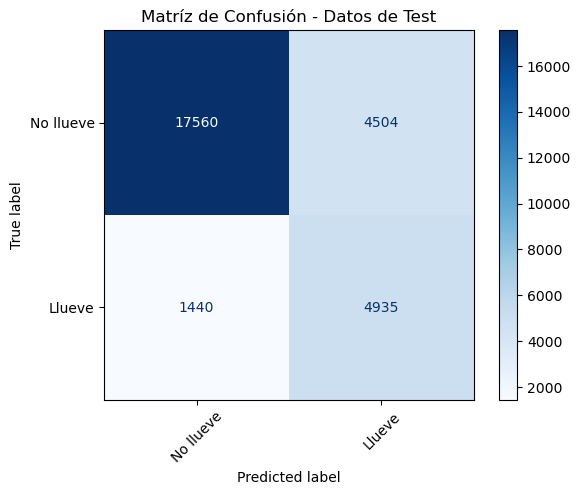

In [15]:
matriz_test =confusion_matrix(y_true = y_test, y_pred = y_test_predict)
ConfusionMatrixDisplay(matriz_test, display_labels=['No llueve', 'Llueve']).plot(cmap=plt.cm.Blues, xticks_rotation=45) #type: ignore
plt.grid(False)
plt.title('Matríz de Confusión - Datos de Test');

In [16]:
print("Métricas en Datos de Test")
reporte_train_1 = classification_report(y_test, y_test_predict, output_dict = True)
df_reporte_train_1 = pd.DataFrame(reporte_train_1).transpose()
df_reporte_train_1.style.background_gradient(cmap = 'Blues').format("{:.2f}")

Métricas en Datos de Test


,precision,recall,f1-score,support
0.0,0.92,0.80,0.86,22064.00
1.0,0.52,0.77,0.62,6375.00
accuracy,0.79,0.79,0.79,0.79
macro avg,0.72,0.78,0.74,28439.00
weighted avg,0.83,0.79,0.80,28439.00


## Red Neuronal

In [17]:
class RedLluvia(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate = 0.0005, epochs = 100, batch_size = 128,
                 capas_ocultas = [64, 64, 32], dropout_rate = 0.25, random_state = None):

        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.capas_ocultas = capas_ocultas
        self.dropout_rate = dropout_rate
        #Threshold óptimo calculado a partir de la precision recall curve
        self.best_threshold_ = 0.5
        self.random_state = random_state
        #Modelo fiteado
        self.model_ = None
        #Necesario para graficar el error de entrenamiento vs. validación
        self.history_ = None
        #Clases aprendidas por el modelo
        self.classes_ = None

    def fit(self, X, y):
        """
        Entrena el modelo y encuentra el mejor threshold de que maximiza el f1_score.
        """
        #Se setea el random state en caso de ser proporcionado
        if self.random_state is not None:
            tf.random.set_seed(self.random_state)
            np.random.seed(self.random_state)
            random.seed(self.random_state)
        #Cantidad de columnas (variables de entrada)
        input_dim = X.shape[1]
        #Clases únicas detectadas
        self.classes_ = np.unique(y)
        #Train-test split del conjunto de entrenamiento, podría considerarse una split para validación
        #útil para el fit del modelo y para el cálculo del mejor umbral para maximizar el f1_score
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size = 0.2, stratify = y, random_state = 42
        )
        #Balanceo de pesos
        pesos = compute_class_weight(
            class_weight = 'balanced',
            classes = self.classes_,
            y = y_train
        )
        class_weights_dict = dict(enumerate(pesos))
        self._construir_modelo(input_dim)
        #Callbacks para early stopping (paciencia alta) para maximizar el f1-score
        #restore_best_weights permite 'guardar' los mejores pesos encontrados hasta el momento
        early_stopper = EarlyStopping(monitor = 'val_loss', patience = 15, restore_best_weights = True)
        reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, min_lr = 1e-6, verbose = 0)
        #Fit del modelo
        self.history_ = self.model_.fit(
            X_train, y_train,
            epochs = self.epochs,
            batch_size = self.batch_size,
            validation_data = (X_test, y_test),
            verbose = 0,
            callbacks = [early_stopper, reduce_lr],
            class_weight = class_weights_dict
        )

        #Una vez fiteado el modelo, hacemos las predicciones (utilizando el método predict del modelo de keras)
        #no confundirse con el método predict de la clase 'RedLluviaPipeline'
        val_probs = self.model_.predict(X_test, verbose=0)

        #Calculamos el umbral óptimo para F1
        precision, recall, thresholds = precision_recall_curve(y_test, val_probs)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)

        mejor_f1_index = np.argmax(f1_scores)

        #Seteamos el umbral optimo como variable interna de la clase, si y solo si es un índice válido
        if mejor_f1_index < len(thresholds):
            self.best_threshold_ = thresholds[mejor_f1_index]
        else:
            self.best_threshold_ = 0.5

        return self
    def predict(self, X):
        """
        Método que realiza predicciones según el umbral óptimo
        """
        if self.model_ is None:
            raise RuntimeError("El modelo no ha sido entrenado todavía.")
        #Predict del modelo de keras
        probabilidades = self.model_.predict(X, verbose = 0)
        #Utilizamos el mejor umbral calculado del fit para nuestras predicciones
        return (probabilidades > self.best_threshold_).astype(int).flatten()

    def predict_proba(self, X):
        """
        Devuelve una lista de diccionarios con las probabilidades para cada clase.
        Ejemplo: [{'negativa': 0.1, 'positiva': 0.9}, ...]
        El índice de la lista se corresponde fila a fila con el orden del dataframe.
        """
        if self.model_ is None:
            raise RuntimeError("El modelo no ha sido entrenado todavía.")

        # Obtenemos la probabilidad de la clase 1
        prob_positiva = self.model_.predict(X, verbose=0).flatten()
        
        # Obtenemos la probabilidad de la clase 0 = 1 - P('clase 1')
        prob_negativa = 1 - prob_positiva

        # Creamos una lista de diccionarios con las probabilidades
        resultados = []
        for p_neg, p_pos in zip(prob_negativa, prob_positiva):
            resultados.append({
                "clase_0_no": round(float(p_neg), 2),
                "clase_1_yes": round(float(p_pos), 2)
            })
            
        return resultados

    def _construir_modelo(self, input_dim):
        """Método interno de la clase para construir el modelo según los parámetros de inicialización"""
        
        #Modelo secuencial
        self.model_ = models.Sequential()
        #Para cada capa oculta seteamos una semilla. 
        #Si es la primera, definimos también la capa de entrada.
        #Se asigna el dropout fijo a las siguientes capas ocultas
        for i, neuronas in enumerate(self.capas_ocultas):
            seed_capa = self.random_state + i if self.random_state else None
            if i == 0:
                self.model_.add(layers.Dense(neuronas, activation='relu', input_shape = (input_dim,)))
            else:
                self.model_.add(layers.Dense(neuronas, activation = 'relu'))
            self.model_.add(layers.Dropout(self.dropout_rate, seed = seed_capa))

        #Salida sigmoidea porque necesitamos predicción 0 o 1
        self.model_.add(layers.Dense(1, activation='sigmoid'))

        optimizador = optimizers.Adam(learning_rate = self.learning_rate)
        self.model_.compile(optimizer = optimizador,
                            loss = 'binary_crossentropy',
                            metrics = ['accuracy'])
    
    def _graficar_evolucion(self):
        """Método para graficar la evolución del entrenamiento"""
        if self.history_ is None:
            raise RuntimeError("El modelo no ha sido entrenado todavía.")
        hist = self.history_.history
        loss = hist['loss']
        val_loss = hist['val_loss']
        accuracy = hist['accuracy']
        val_accuracy = hist['val_accuracy']

        rango_epocas = range(1, len(loss) + 1)

        plt.figure(figsize = (14, 5))
        plt.subplot(1, 2, 1)
        plt.plot(rango_epocas, loss, label='Error de entrenamiento')
        plt.plot(rango_epocas, val_loss, label='Error de validación')
        plt.title('Evolución de la Pérdida')
        plt.xlabel('Época')
        plt.ylabel('Pérdida (Binary Crossentropy)')
        plt.legend(loc='upper right')
        plt.grid(True, linestyle = '--', alpha = 0.6)

        plt.subplot(1, 2, 2)
        plt.plot(rango_epocas, accuracy, label = 'Train Accuracy')
        plt.plot(rango_epocas, val_accuracy, label = 'Val Accuracy')
        plt.title('Evolución del Accuracy')
        plt.xlabel('Época')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.grid(True, linestyle = '--', alpha = 0.6)

        plt.tight_layout()
        plt.show()
    
    def __getstate__(self):
        """
        Prepara el objeto para ser guardado con Pickle/Joblib.
        TensorFlow no es compatible con pickle, así que guardamos los pesos manualmente.
        """
        state = self.__dict__.copy()
        if self.model_ is not None:
            state['model_weights_'] = self.model_.get_weights()
            state['input_dim_'] = self.model_.input_shape[1]

        if 'model_' in state:
            del state['model_']

        if 'history_' in state:
            del state['history_']
            
        return state

    def __setstate__(self, state):
        """
        Restaura el objeto desde Pickle/Joblib.
        Reconstruye el modelo de Keras y le carga los pesos.
        """
        self.__dict__.update(state)

        if 'model_weights_' in state:
            self._construir_modelo(state['input_dim_'])
            self.model_.set_weights(state['model_weights_'])
            del self.model_weights_
            del self.input_dim_
        else:
            self.model_ = None

In [ ]:
modelo_red_neuronal = RedLluvia(learning_rate = 0.0005, epochs = 100, batch_size = 128,
                 capas_ocultas = [64, 64, 32], dropout_rate = 0.25, random_state = 42)
# --- EL PIPELINE FINAL ---
pipeline_red_neuronal = Pipeline([
    # Paso 1: Generar Mes y Temporada
    ('feature_eng_date', transformer_fechas),
    
    # Paso 2: Generar Región (Spatial Join)
    ('feature_eng_geo', AgregadorEspacial('./Shapefiles/NRM_clusters.shp')),
    
    # Paso 3: Limpiar, Imputar y Escalar (todo lo generado en 1 y 2 + lo original)
    ('preprocesamiento', preprocessor),
    
    # Paso 4: El Modelo
    ('clasificador', modelo_logistico) # Ej: LogisticRegression()
])

pipeline_red_neuronal.fit(X_train, y_train)
y_test_predict = pipeline_red_neuronal.predict(X_test)

## HGBClassifier

In [18]:
# Importamos la implementación de sklearn
from sklearn.ensemble import HistGradientBoostingClassifier

# Instanciamos el modelo
# - learning_rate: Qué tan rápido aprende (menor es más preciso pero más lento)
# - max_iter: Equivalente a 'n_estimators' o número de árboles
modelo_lgbm_sklearn = HistGradientBoostingClassifier(
    learning_rate=0.01,
    max_iter=100,
    random_state=42,
    class_weight='balanced'
    # categorical_features: Opcional, si le pasas una máscara booleana de cuáles cols son categóricas
)

# Creamos el Pipeline con el NUEVO modelo
pipeline_lgbm = Pipeline([
    # Paso 1: Fechas
    ('feature_eng_date', transformer_fechas),
    
    # Paso 2: Geo
    ('feature_eng_geo', AgregadorEspacial('./Shapefiles/NRM_clusters.shp')),
    
    # Paso 3: Limpieza (Nota: HistGradientBoosting tolera nulos, pero el OneHotEncoder de tu pipe_cat NO,
    # así que mantén tu 'pipeline_procesamiento' tal cual está para las categóricas).
    ('preprocesamiento', preprocessor),
    
    # Paso 4: El Modelo LightGBM de Sklearn
    ('clasificador', modelo_lgbm_sklearn) 
])

# Entrenar y Validar
pipeline_lgbm.fit(X_train, y_train)
print("Score en Test:", pipeline_lgbm.score(X_test, y_test))

Score en Test: 0.7864200569640283


Reporte de Clasificación - HistGradientBoosting:
              precision    recall  f1-score   support

         0.0       0.92      0.79      0.85     22064
         1.0       0.52      0.77      0.62      6375

    accuracy                           0.79     28439
   macro avg       0.72      0.78      0.73     28439
weighted avg       0.83      0.79      0.80     28439



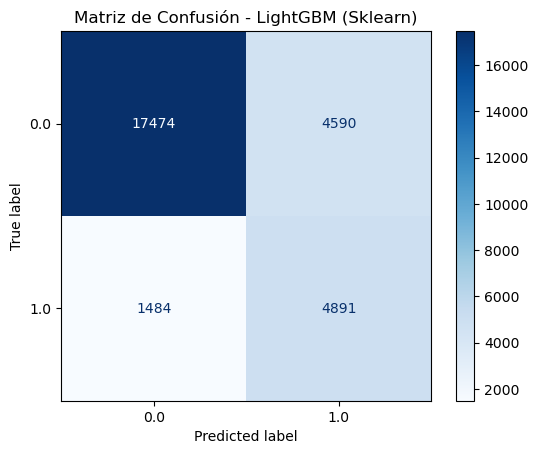

In [19]:
# 1. Predecir las clases
y_pred_lgbm = pipeline_lgbm.predict(X_test)

# 2. Ver el reporte detallado
print("Reporte de Clasificación - HistGradientBoosting:")
print(classification_report(y_test, y_pred_lgbm))

# 3. Ver la matriz de confusión (para ver dónde se equivoca)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lgbm, cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - LightGBM (Sklearn)")
plt.show()

## Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

modelo_rf = RandomForestClassifier(
    n_estimators= 100,
    random_state=42
)

# Creamos el Pipeline con el NUEVO modelo
pipeline_rf = Pipeline([
    # Paso 1: Fechas
    ('feature_eng_date', transformer_fechas),
    
    # Paso 2: Geo
    ('feature_eng_geo', AgregadorEspacial('./Shapefiles/NRM_clusters.shp')),
    
    ('preprocesamiento', preprocessor),
    
    # Paso 4: El Modelo LightGBM de Sklearn
    ('clasificador', modelo_rf) 
])

# Entrenar y Validar
pipeline_rf.fit(X_train, y_train)
print("Score en Test:", pipeline_lgbm.score(X_test, y_test))

Score en Test: 0.7864200569640283


Reporte de Clasificación - HistGradientBoosting:
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91     22064
         1.0       0.77      0.50      0.61      6375

    accuracy                           0.86     28439
   macro avg       0.82      0.73      0.76     28439
weighted avg       0.85      0.86      0.84     28439



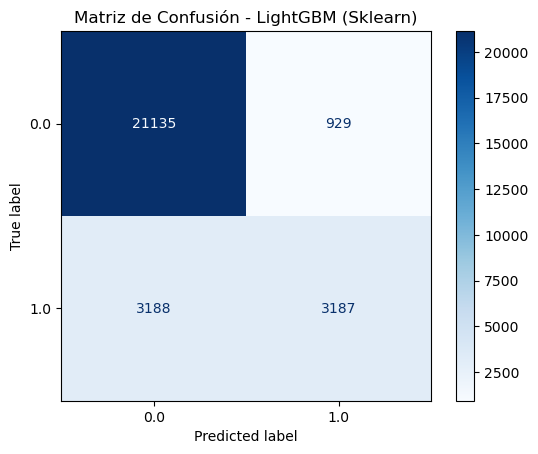

In [ ]:
# 1. Predecir las clases
y_pred_rf = pipeline_rf.predict(X_test)

# 2. Ver el reporte detallado
print("Reporte de Clasificación - HistGradientBoosting:")
print(classification_report(y_test, y_pred_rf))

# 3. Ver la matriz de confusión (para ver dónde se equivoca)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap = plt.cm.Blues)
plt.title("Matriz de Confusión - LightGBM (Sklearn)")
plt.show()